## 3 Preprocessing

In [1]:
import pandas as pd

data = pd.read_csv("data.csv")
data = data[data.shot_made_flag.isnull()==False] # 같은 표현 : data = data.dropna()

In [2]:
X = data.ix[:,data.columns != 'shot_made_flag'].copy() # 'shot_made_flag'를 제외한 모든 columns를 선택
y = data.shot_made_flag.copy()

/Users/kth/miniconda3/envs/ml/lib/python3.6/site-packages/ipykernel_launcher.py:1: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#ix-indexer-is-deprecated
  """Entry point for launching an IPython kernel.


### 3-1 불필요한 feature 제거

In [3]:
for col in X.columns:
    print(col)

action_type
combined_shot_type
game_event_id
game_id
lat
loc_x
loc_y
lon
minutes_remaining
period
playoffs
season
seconds_remaining
shot_distance
shot_type
shot_zone_area
shot_zone_basic
shot_zone_range
team_id
team_name
game_date
matchup
opponent
shot_id


In [4]:
X.drop('game_id', axis=1, inplace=True) # Independent
X.drop('game_event_id', axis=1, inplace=True) # Independent

X.drop('lat', axis=1, inplace=True) # Correlated with loc_x
X.drop('lon', axis=1, inplace=True) # Correlated with loc_y

X.drop('team_id', axis=1, inplace=True) # Always one number
X.drop('team_name', axis=1, inplace=True) # Always LA Lakers

In [5]:
X.head()

action_type combined_shot_type  loc_x  loc_y  minutes_remaining  \
1          Jump Shot          Jump Shot   -157      0                 10   
2          Jump Shot          Jump Shot   -101    135                  7   
3          Jump Shot          Jump Shot    138    175                  6   
4  Driving Dunk Shot               Dunk      0      0                  6   
5          Jump Shot          Jump Shot   -145    -11                  9   

   period  playoffs   season  seconds_remaining  shot_distance  \
1       1         0  2000-01                 22             15   
2       1         0  2000-01                 45             16   
3       1         0  2000-01                 52             22   
4       2         0  2000-01                 19              0   
5       3         0  2000-01                 32             14   

        shot_type         shot_zone_area  shot_zone_basic  shot_zone_range  \
1  2PT Field Goal           Left Side(L)        Mid-Range         8-16 ft.   
2  2PT Field Goal   Left Side Center(LC)        Mid-Range        16-24 ft.   
3  2PT Field Goal  Right Side Center(RC)        Mid-Range        16-24 ft.   
4  2PT Field Goal              Center(C)  Restricted Area  Less Than 8 ft.   
5  2PT Field Goal           Left Side(L)        Mid-Range         8-16 ft.   

    game_date    matchup opponent  shot_id  
1  2000-10-31  LAL @ POR      POR        2  
2  2000-10-31  LAL @ POR      POR        3  
3  2000-10-31  LAL @ POR      POR        4  
4  2000-10-31  LAL @ POR      POR        5  
5  2000-10-31  LAL @ POR      POR        6

## 3-2 Data Transformation

In [6]:
# Remaining time
X['seconds_from_period_end'] = 60 * X['minutes_remaining'] + X['seconds_remaining']
X['last_5_sec_in_period'] = X['seconds_from_period_end'] < 5

X.drop('minutes_remaining', axis=1, inplace=True)
X.drop('seconds_remaining', axis=1, inplace=True)
X.drop('seconds_from_period_end', axis=1, inplace=True)

## Matchup - (away/home)
X['home_play'] = X['matchup'].str.contains('vs').astype('int')
X.drop('matchup', axis=1, inplace=True)

# drop correlated featuers
X.drop('action_type', axis=1, inplace=True)
X.drop('shot_zone_basic', axis=1, inplace=True)
X.drop('season', axis=1, inplace=True)

# Game date
X['game_date'] = pd.to_datetime(X['game_date'])
X['game_year'] = X['game_date'].dt.year
X['game_month'] = X['game_date'].dt.month
X.drop('game_date', axis=1, inplace=True)

# Loc_x, and loc_y binning
X['loc_x'] = pd.cut(X['loc_x'], 25)
X['loc_y'] = pd.cut(X['loc_y'], 25)

# Replace 20 least common action types with value 'Other'
# rare_action_types = X['action_type'].value_counts().sort_values().index.values[:20]
# X.loc[X['action_type'].isin(rare_action_types), 'action_type'] = 'Other'

## 3-3 Categorical variable to dummies

In [7]:
categorial_cols = [
    'combined_shot_type', 'period', 'shot_type',
    'shot_zone_area', 'shot_zone_range', 'game_year',
    'game_month', 'opponent', 'loc_x', 'loc_y']

for cc in categorial_cols:
    dummies = pd.get_dummies(X[cc])
    dummies = dummies.add_prefix("{}-".format(cc))
    X.drop(cc, axis=1, inplace=True)
    X = X.join(dummies)

In [8]:
X.head()

playoffs  shot_distance  shot_id  last_5_sec_in_period  home_play  \
1         0             15        2                 False          0   
2         0             16        3                 False          0   
3         0             22        4                 False          0   
4         0              0        5                 False          0   
5         0             14        6                 False          0   

   combined_shot_type-Bank Shot  combined_shot_type-Dunk  \
1                             0                        0   
2                             0                        0   
3                             0                        0   
4                             0                        1   
5                             0                        0   

   combined_shot_type-Hook Shot  combined_shot_type-Jump Shot  \
1                             0                             1   
2                             0                             1   
3                             0                             1   
4                             0                             0   
5                             0                             1   

   combined_shot_type-Layup          ...           loc_y-(457.0, 490.4]  \
1                         0          ...                              0   
2                         0          ...                              0   
3                         0          ...                              0   
4                         0          ...                              0   
5                         0          ...                              0   

   loc_y-(490.4, 523.8]  loc_y-(523.8, 557.2]  loc_y-(557.2, 590.6]  \
1                     0                     0                     0   
2                     0                     0                     0   
3                     0                     0                     0   
4                     0                     0                     0   
5                     0                     0                     0   

   loc_y-(590.6, 624.0]  loc_y-(624.0, 657.4]  loc_y-(657.4, 690.8]  \
1                     0                     0                     0   
2                     0                     0                     0   
3                     0                     0                     0   
4                     0                     0                     0   
5                     0                     0                     0   

   loc_y-(690.8, 724.2]  loc_y-(724.2, 757.6]  loc_y-(757.6, 791.0]  
1                     0                     0                     0  
2                     0                     0                     0  
3                     0                     0                     0  
4                     0                     0                     0  
5                     0                     0                     0  

[5 rows x 144 columns]

- 총 207개 features

## 4 Model

### 4-1 Base model
- 가장 기본적인 모델, Logistic regression, LDA, KNN, Decision Tree, Naive Bayes, SVM을 사용하여 평가해보자

In [9]:
from sklearn.model_selection import cross_val_score

# setting parameters
seed = 7
processors=1
kfold=5
num_instances=len(X)
scoring='log_loss'

In [10]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

# base model를 활용하기 위한 package
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC

In [11]:
# Prepare some basic models
models = []
models.append(('LR', LogisticRegression()))
models.append(('LDA', LinearDiscriminantAnalysis()))
models.append(('K-NN', KNeighborsClassifier(n_neighbors=5)))
models.append(('CART', DecisionTreeClassifier()))
models.append(('NB', GaussianNB()))

results = []
names = []
print('all features selected')
for name, model in models:
    cv_results = cross_val_score(model, X, y, cv=kfold, n_jobs=processors) # accuracy를 보려면 scoring을 지우면 default처리
    results.append(cv_results)
    names.append(name)
    print("{0}: ({1:.3f}) +/- ({2:.3f})".format(name, cv_results.mean(), cv_results.std()))   
print('\n')  

all features selected
LR: (0.604) +/- (0.009)


/Users/kth/miniconda3/envs/ml/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
/Users/kth/miniconda3/envs/ml/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
/Users/kth/miniconda3/envs/ml/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
/Users/kth/miniconda3/envs/ml/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
/Users/kth/miniconda3/envs/ml/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")


LDA: (0.594) +/- (0.021)
K-NN: (0.478) +/- (0.042)
CART: (0.498) +/- (0.037)
NB: (0.581) +/- (0.011)




In [12]:
corr = X.corr()
cut_off = 0.8

for col in corr.columns:
    tmp = (corr[col] < 1) & (corr[col] > cut_off)
    try:
        if corr[col][tmp.values].values:
            print(col, corr[col][tmp.values])
    except:
        print(corr[col][tmp.values].values)

shot_type-3PT Field Goal shot_zone_range-24+ ft.    0.98394
Name: shot_type-3PT Field Goal, dtype: float64
shot_zone_range-24+ ft. shot_type-3PT Field Goal    0.98394
Name: shot_zone_range-24+ ft., dtype: float64


In [13]:
corr

playoffs  shot_distance   shot_id  \
playoffs                              1.000000  -7.751105e-03  0.612991   
shot_distance                        -0.007751   1.000000e+00  0.020464   
shot_id                               0.612991   2.046404e-02  1.000000   
last_5_sec_in_period                  0.005305   1.550626e-01 -0.006309   
home_play                            -0.008559  -4.303225e-02 -0.012026   
combined_shot_type-Bank Shot          0.002344  -3.428082e-02  0.021188   
combined_shot_type-Dunk              -0.010226  -2.930513e-01 -0.029924   
combined_shot_type-Hook Shot         -0.010322  -5.916855e-02  0.010887   
combined_shot_type-Jump Shot          0.005355   7.520901e-01  0.021581   
combined_shot_type-Layup             -0.000223  -6.426589e-01 -0.014853   
combined_shot_type-Tip Shot           0.005416  -1.087283e-01  0.003524   
period-1                             -0.004221  -2.864939e-02  0.000351   
period-2                              0.006367  -1.324076e-02  0.010091   
period-3                             -0.012366  -1.231267e-02 -0.016117   
period-4                              0.012531   5.516913e-02  0.011091   
period-5                              0.000055   5.220565e-07 -0.014214   
period-6                             -0.014150   3.312160e-03 -0.011493   
period-7                             -0.006832   1.708050e-03  0.000635   
shot_type-2PT Field Goal              0.013631  -6.682821e-01 -0.043572   
shot_type-3PT Field Goal             -0.013631   6.682821e-01  0.043572   
shot_zone_area-Back Court(BC)         0.007231   2.365875e-01 -0.002393   
shot_zone_area-Center(C)              0.013773  -6.527746e-01  0.005326   
shot_zone_area-Left Side Center(LC)  -0.010435   3.721994e-01  0.006340   
shot_zone_area-Left Side(L)           0.007059   6.000941e-02  0.002342   
shot_zone_area-Right Side Center(RC) -0.014364   3.923559e-01 -0.001138   
shot_zone_area-Right Side(R)         -0.002266   6.809685e-02 -0.014023   
shot_zone_range-16-24 ft.            -0.007477   3.290301e-01 -0.041740   
shot_zone_range-24+ ft.              -0.014257   6.385140e-01  0.038538   
shot_zone_range-8-16 ft.              0.019223  -8.294467e-02  0.021209   
shot_zone_range-Back Court Shot       0.007231   2.365875e-01 -0.002393   
...                                        ...            ...       ...   
loc_x-(148.4, 168.32]                -0.009426   1.479661e-01 -0.021582   
loc_x-(168.32, 188.24]               -0.005386   1.404745e-01 -0.008242   
loc_x-(188.24, 208.16]                0.002735   1.388337e-01  0.006714   
loc_x-(208.16, 228.08]                0.001908   1.275984e-01  0.011179   
loc_x-(228.08, 248.0]                -0.016142   1.052425e-01  0.000063   
loc_y-(-44.835, -10.6]                0.006819   3.531455e-02 -0.007618   
loc_y-(-10.6, 22.8]                  -0.012690  -6.495069e-01 -0.042125   
loc_y-(22.8, 56.2]                    0.008385  -1.320707e-01  0.024121   
loc_y-(56.2, 89.6]                    0.016980  -5.885409e-02  0.013550   
loc_y-(89.6, 123.0]                   0.008210   6.380753e-02  0.009472   
loc_y-(123.0, 156.4]                 -0.004462   1.713759e-01 -0.010053   
loc_y-(156.4, 189.8]                 -0.011228   2.580148e-01 -0.008584   
loc_y-(189.8, 223.2]                 -0.003091   3.221181e-01  0.018235   
loc_y-(223.2, 256.6]                  0.002666   3.188166e-01  0.020309   
loc_y-(256.6, 290.0]                 -0.003555   1.889504e-01  0.019743   
loc_y-(290.0, 323.4]                 -0.002374   7.693280e-02 -0.003848   
loc_y-(323.4, 356.8]                  0.012144   6.701231e-02  0.006983   
loc_y-(356.8, 390.2]                 -0.004128   7.838711e-02  0.002468   
loc_y-(390.2, 423.6]                 -0.011551   8.410508e-02 -0.015701   
loc_y-(423.6, 457.0]                  0.008092   5.134387e-02  0.007786   
loc_y-(457.0, 490.4]                 -0.006832   6.073341e-02 -0.009754   
loc_y-(490.4, 523.8]                  0.005182   7.080186e-02  

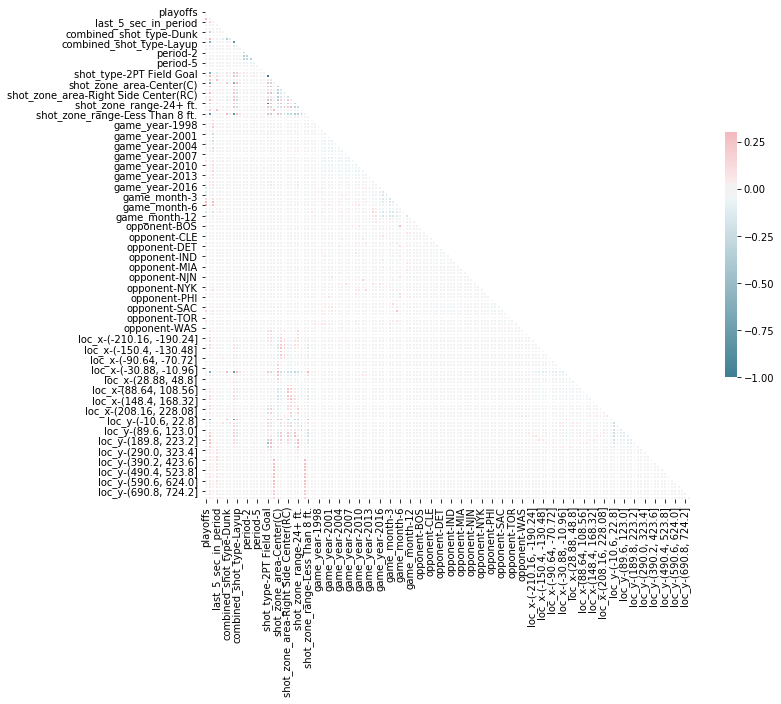

In [19]:
# Generate a mask for the upper triangle
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(11, 9))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(220, 10, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.3, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})